# import libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.metrics import confusion_matrix


# Generate Dataset

## Read data
Chia (70%, 20%, 10%) cho các tập huấn luyện, xác thực và thử nghiệm.

In [27]:
train_df = pd.read_csv('./processed_data/trainset.csv')
val_df = pd.read_csv('./processed_data/valset.csv')
test_df = pd.read_csv('./processed_data/testset.csv')


date_time = pd.to_datetime(test_df.pop('Formatted Date'), format='%Y-%m-%d %H:%M:%S.%f %z')
train_df.drop(['Formatted Date'],axis=1,inplace=True)
val_df.drop(['Formatted Date'],axis=1,inplace=True)



In [28]:
test_df.shape


(9646, 39)

# Parameter

In [29]:
n_timestep = 15
n_timepred = 1
n_feature = len(train_df.columns)


## Scale


In [30]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
scaler = MinMaxScaler()
train_df = scaler.fit_transform(train_df)
val_df = scaler.fit_transform(val_df)
test_df = scaler.fit_transform(test_df)

### Splitting

In [32]:
def timestep_split(data, n_step):
    x, y = [], []

    length = len(data)
    for i in range(n_step, length):
        x.append(data[i-n_step:i])
        y.append(data[i])

    print(len(x))
    return np.array(x), np.array(y)

In [33]:
x_train, y_train = timestep_split(data=train_df, n_step=n_timestep)
x_val, y_val = timestep_split(data=val_df, n_step=n_timestep)
x_test, y_test = timestep_split(data=test_df, n_step=n_timestep)

67502
19275
9631


In [34]:
len(date_time)

9646

In [35]:
len(x_test)

9631

In [36]:
x_train[0], y_train[0]

(array([[0.        , 0.36288363, 0.35291194, 0.89      , 0.62      ,
         0.51659076, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.34938665, 0.63960519,
         0.37059048, 0.98296291, 0.50196398, 0.99999614],
        [0.        , 0.37233372, 0.36500704, 0.85      , 0.615     ,
         0.50829538, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 

# Build model LSTM

In [37]:
model = keras.models.Sequential()

model.add(Input(shape=(n_timestep,n_feature), name='Input'))

model.add(LSTM(units=64,
               activation='tanh',
               recurrent_activation='sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               dropout=0.0,
               recurrent_dropout=0.0,
               return_sequences=True,
               name='LSTM_many_to_many'))

model.add(LSTM(units=64,
               activation='tanh',
               recurrent_activation='sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               dropout=0.0,
               recurrent_dropout=0.0,
               name='LSTM_many_to_one'))

model.add(Dense(units=n_feature,
                activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                name='Output_layer'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               beta_1=0.9,
                               beta_2=0.999,
                               epsilon=1e-08)

model.compile(optimizer=opt, loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_many_to_many (LSTM)    (None, 15, 64)            26624     
                                                                 
 LSTM_many_to_one (LSTM)     (None, 64)                33024     
                                                                 
 Output_layer (Dense)        (None, 39)                2535      
                                                                 
Total params: 62,183
Trainable params: 62,183
Non-trainable params: 0
_________________________________________________________________


In [38]:
tf.keras.utils.plot_model(model,to_file='/kaggle/working/model_LSTM.png', show_layer_activations=True, show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train

In [39]:
path = './model/LSTM_model_15timesteps.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True)

In [40]:
model.fit(x_train, y_train, epochs=10, verbose=0, callbacks=[checkpoint], batch_size=256,validation_data=(x_val, y_val), validation_batch_size=256)

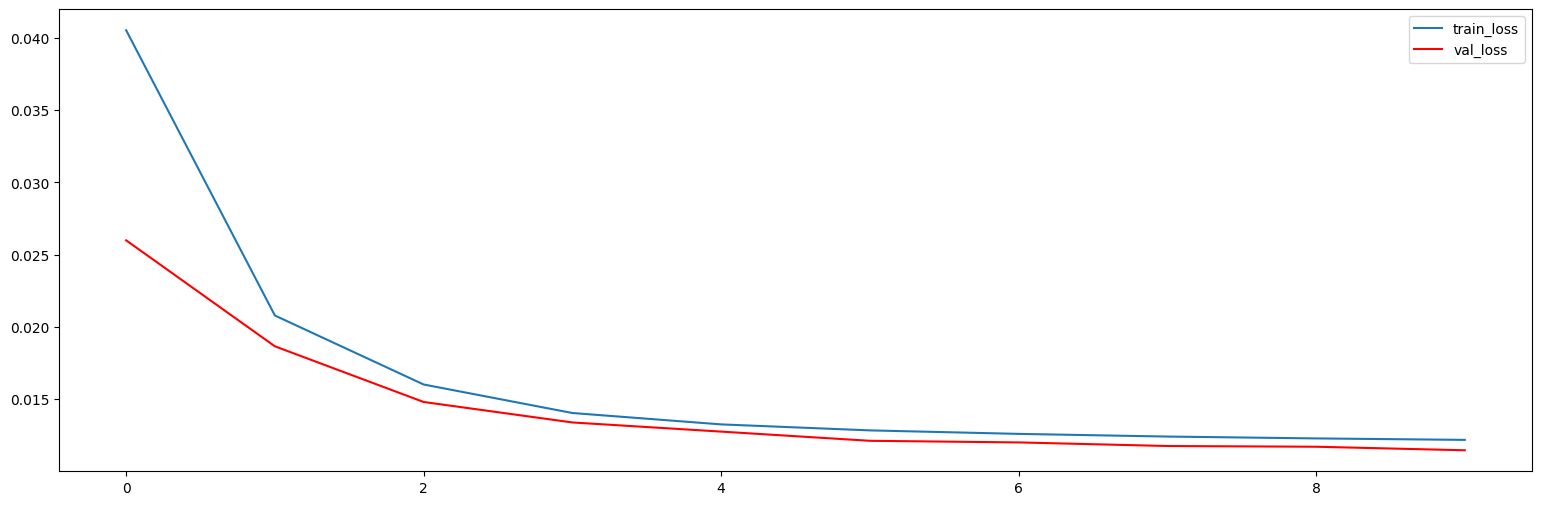

In [41]:
plt.figure(figsize=(19, 6))
plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['val_loss'], c='red', label='val_loss')
plt.legend()

# Evaluate

In [42]:
#load best model
model = keras.models.load_model(path)

In [43]:
y_predict = model.predict(x_test)

y_predict_inverse = scaler.inverse_transform(y_predict)
y_test_inverse = scaler.inverse_transform(y_test)

301/301 [==============================] - 5s 10ms/step


In [44]:
y_predict_inverse[0]

array([ 8.00223723e-02,  5.66274881e+00,  2.70140862e+00,  8.98144603e-01,
        9.05478954e+00,  1.00778046e+03,  3.84385465e-03,  8.76954943e-03,
        5.43985609e-03,  8.47764779e-03,  1.07447831e-02,  6.27032761e-03,
        1.79417860e-02,  9.99377016e-03,  2.83335289e-03,  5.59490966e-03,
        8.14056396e-03,  6.94987085e-03,  3.21348272e-02,  2.96160905e-03,
        8.34857114e-03,  5.60196396e-03,  4.70019458e-03,  1.44745469e-01,
        8.74908209e-01,  1.44624719e-02,  7.24149030e-03,  7.24302232e-03,
        6.45829272e-03,  5.61417406e-03,  6.06053229e-03,  8.02290160e-03,
        4.88849450e-03,  1.08494196e+01, -2.92175317e+00, -8.88821244e-01,
       -5.84559321e-01, -3.91779184e-01,  8.69821429e-01], dtype=float32)

In [45]:
y_test_inverse[0]

array([ 0.00000000e+00,  2.85000000e+00,  2.83333333e-01,  8.80000000e-01,
        9.98200000e+00,  1.01025000e+03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.27360000e+00,  0.00000000e+00, -8.66025404e-01,
       -5.00000000e-01, -5.73275481e-01,  8.19362693e-01])

In [46]:
# from sklearn.metrics import accuracy_score
# accuracy_score(y_test_inverse, y_predict_inverse)

## Precip Type

In [47]:
rain = y_predict_inverse[:,0] < 0.5
snow = y_predict_inverse[:,0] >= 0.5
y_predict_inverse[rain,0] = 0
y_predict_inverse[snow,0] = 1

In [48]:
BA = keras.metrics.BinaryAccuracy(threshold=0.5)
BA.update_state(y_test_inverse[:,0], y_predict_inverse[:,0])
R_Accuracy = float(BA.result())
print('Độ chính xác khi dự đoán mưa hay không: {:.2f}%'.format(R_Accuracy*100))

Độ chính xác khi dự đoán mưa hay không: 97.84%


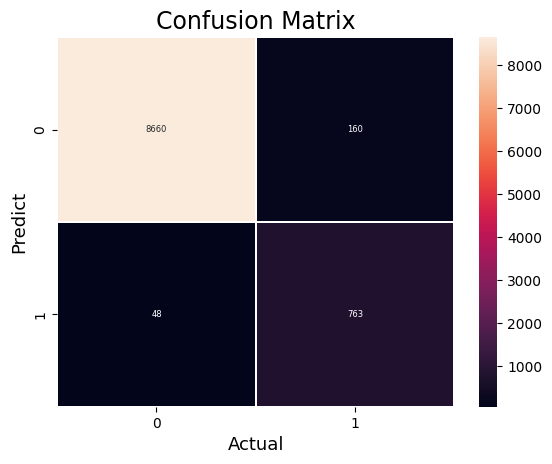

In [49]:
# compute the confusion matrix
cm = confusion_matrix(y_test_inverse[:,0], y_predict_inverse[:,0])
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            linewidths= 0.2,
            annot_kws={"size": 6})
plt.xlabel('Actual',fontsize=13)
plt.ylabel('Predict',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)

plt.show()

## Temperature

In [50]:
from keras.metrics import mean_absolute_error

In [51]:
# mean absolute error
mean = float(mean_absolute_error(y_test_inverse[:,1], y_predict_inverse[:,1]))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 2.318


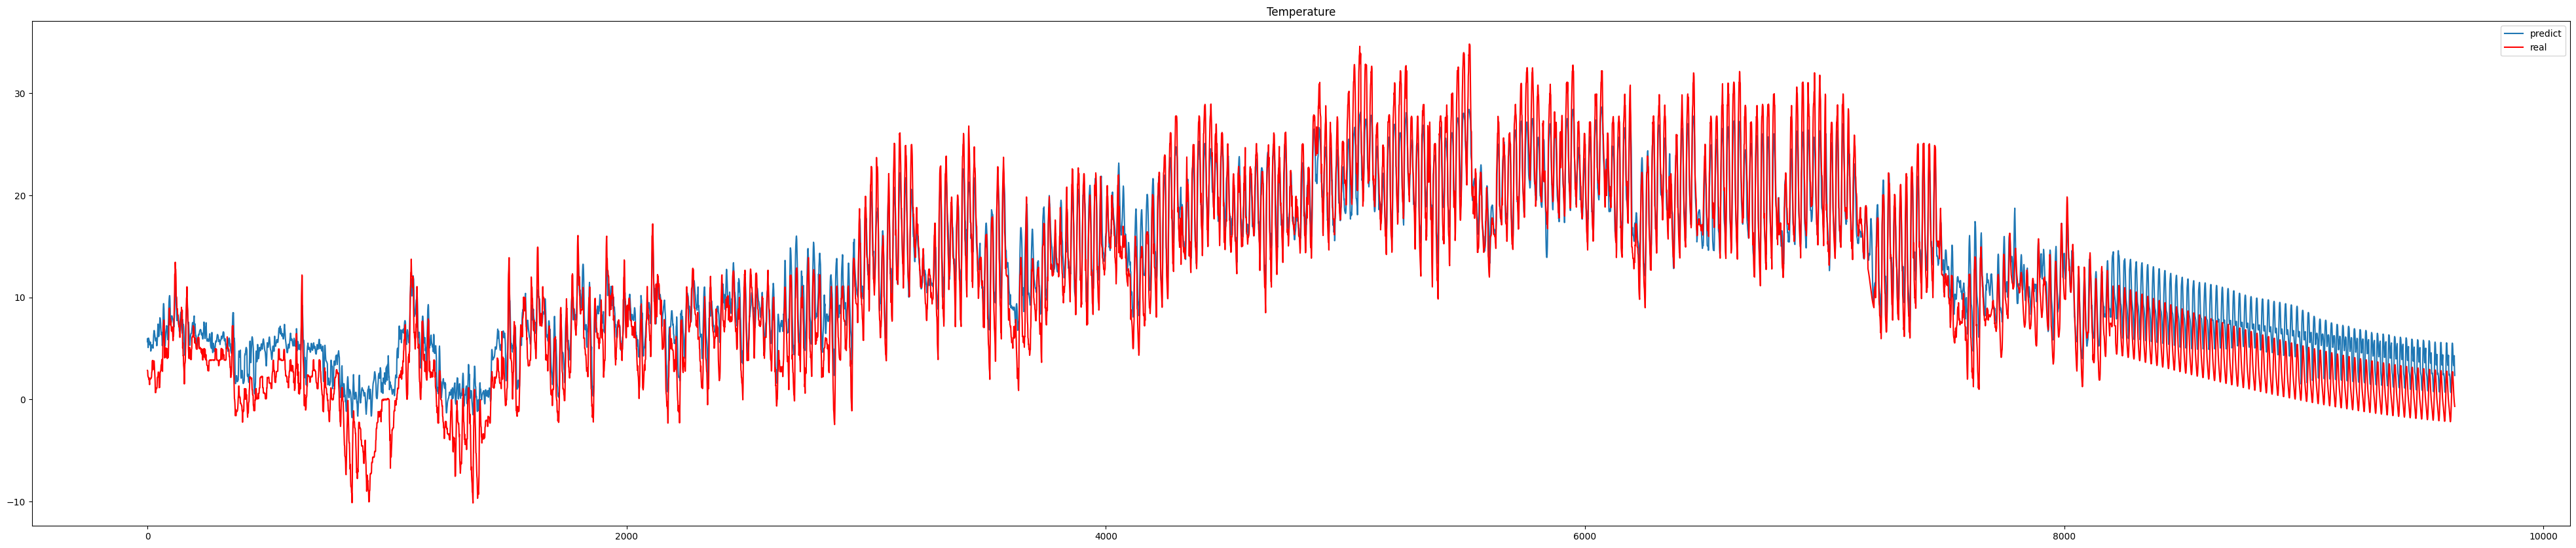

In [52]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(datetime, y_predict_inverse[:,1], label='predict')
plt.plot( y_test_inverse[:,1], c='red', label='real')
plt.title('Temperature')
plt.legend()

## Apparent Temperature

In [53]:
# mean absolute error
mean = float(mean_absolute_error(y_test_inverse[:,2], y_predict_inverse[:,2]))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 2.372


In [54]:
len(date_time[n_timestep:])

9631

In [55]:
len(y_predict_inverse[:,2])

9631

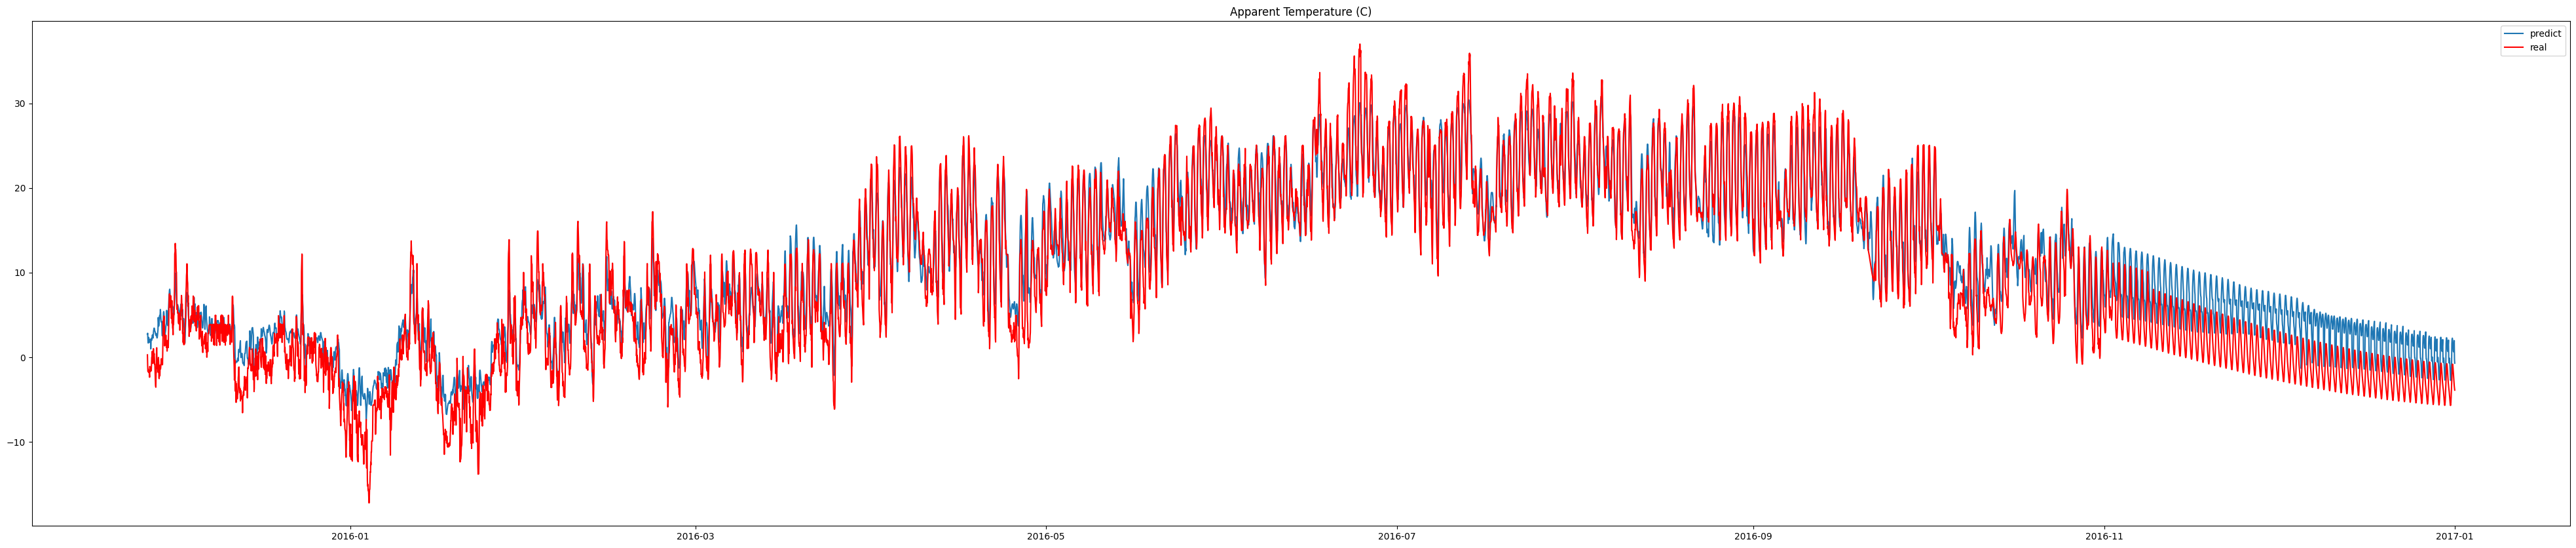

In [56]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[n_timestep:], y_predict_inverse[:,2], label='predict')
plt.plot(date_time[n_timestep:], y_test_inverse[:,2], c='red', label='real')
plt.title('Apparent Temperature (C)')
plt.legend()

## Humidity

In [57]:
# mean absolute error
mean = float(mean_absolute_error(y_test_inverse[:,3], y_predict_inverse[:,3]))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 0.052


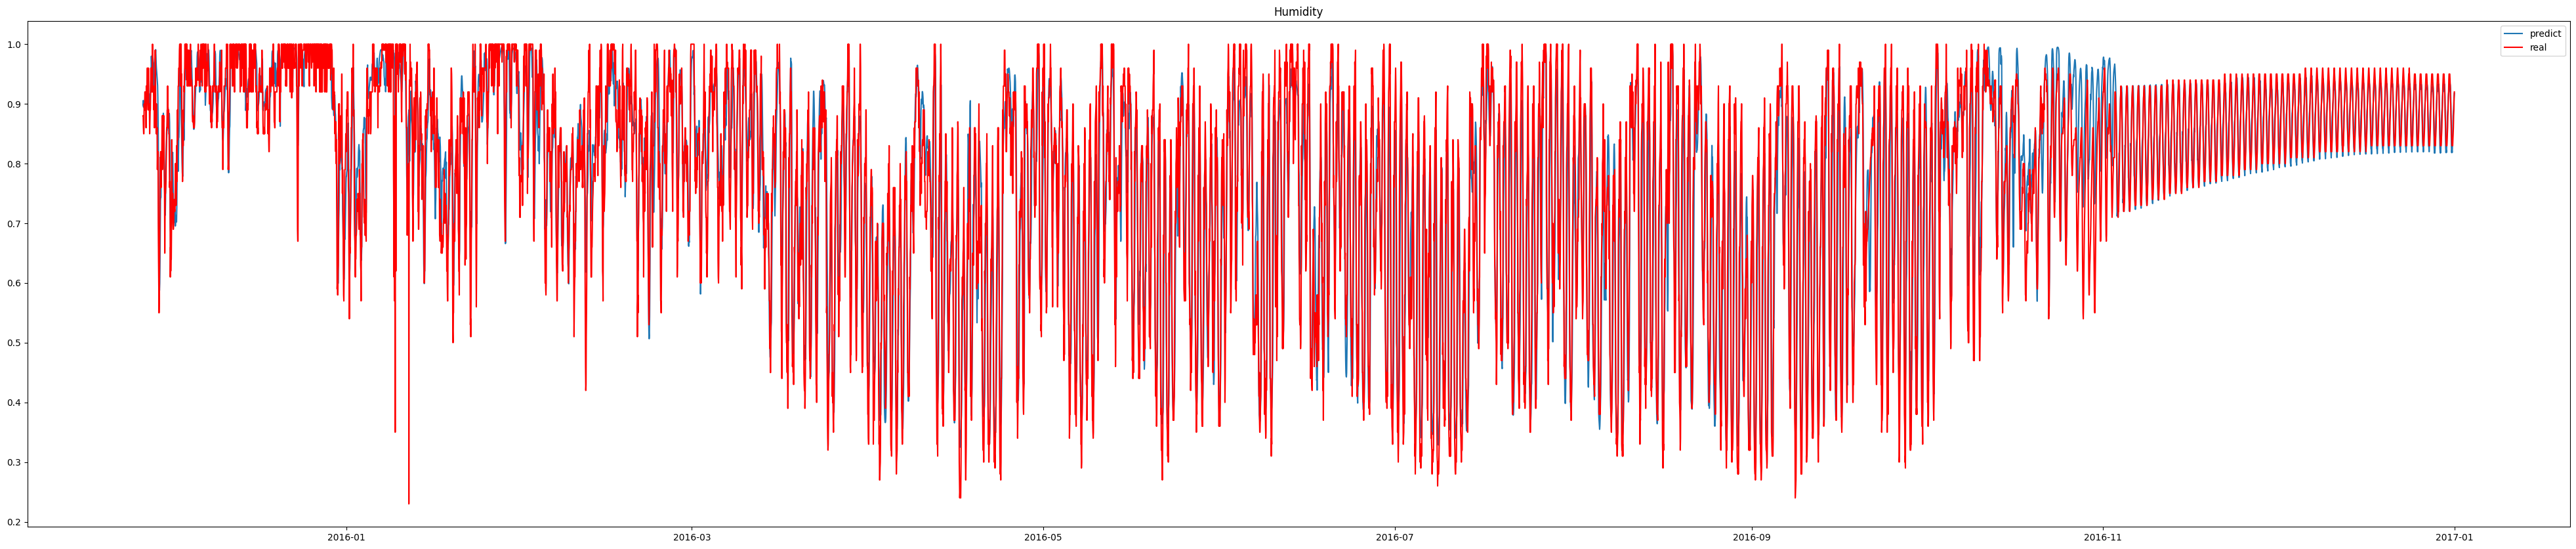

In [59]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[ n_timestep:], y_predict_inverse[:,3], label='predict')
plt.plot(date_time[ n_timestep:], y_test_inverse[:,3], c='red', label='real')
plt.title('Humidity')
plt.legend()

## Visibility

In [60]:
# mean absolute error
mean = float(mean_absolute_error(y_test_inverse[:,4], y_predict_inverse[:,4]))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 1.883


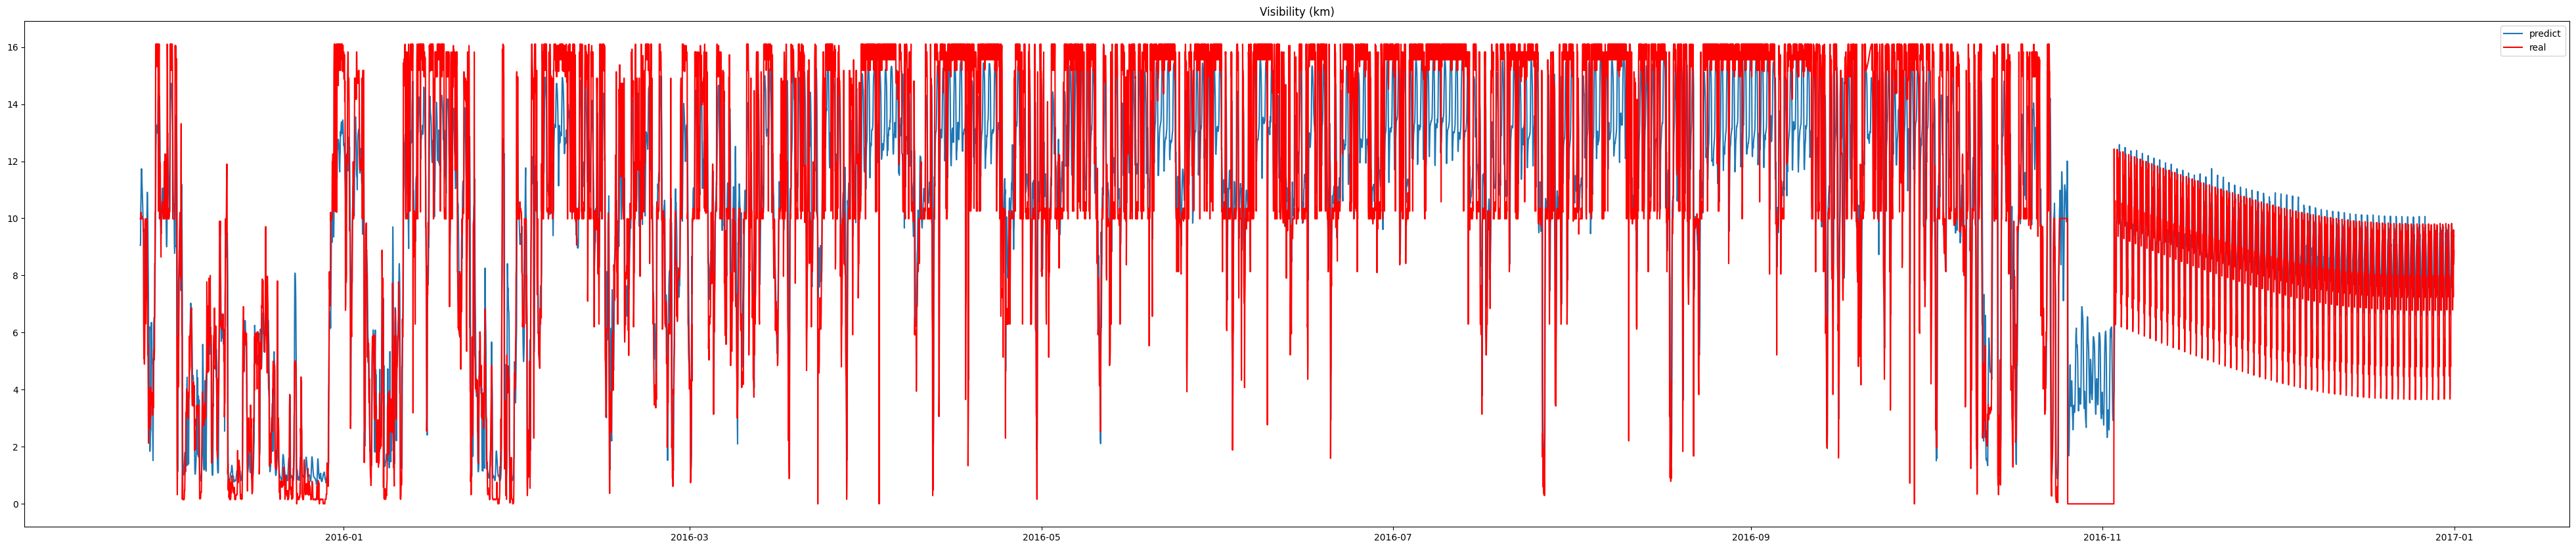

In [62]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[n_timestep:], y_predict_inverse[:,4], label='predict')
plt.plot(date_time[n_timestep:], y_test_inverse[:,4], c='red', label='real')
plt.title('Visibility (km)')
plt.legend()

## Pressure

In [76]:
# mean absolute error
mean = float(mean_absolute_error(y_test_inverse[:,5], y_predict_inverse[:,5]))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 1.751


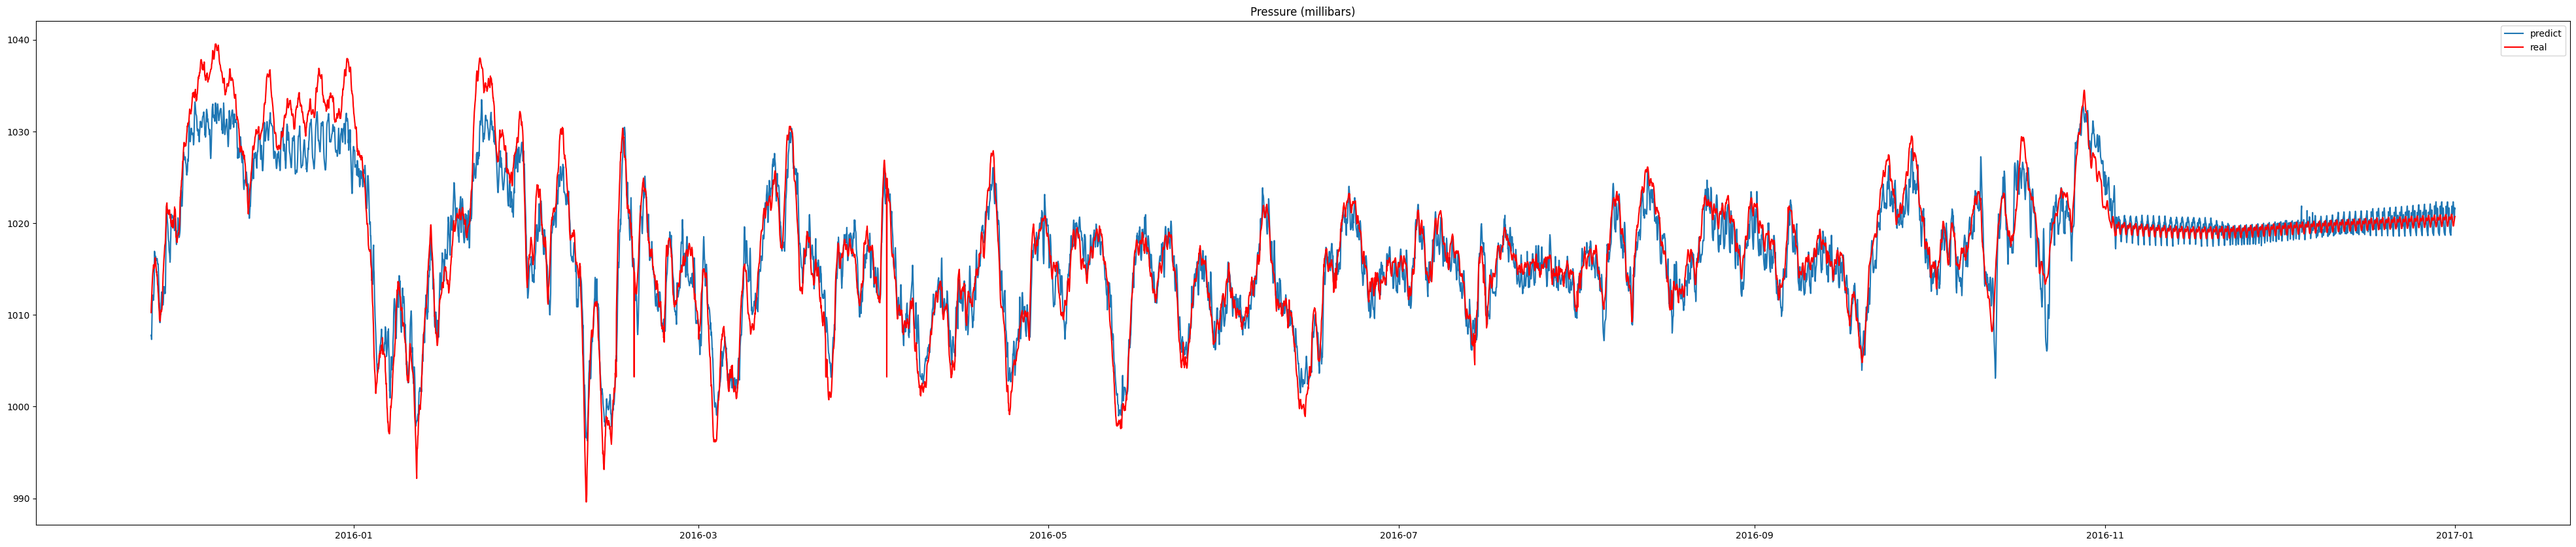

In [63]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[n_timestep:], y_predict_inverse[:,5], label='predict')
plt.plot(date_time[n_timestep:], y_test_inverse[:,5], c='red', label='real')
plt.title('Pressure (millibars)')
plt.legend()

## Summary

In [65]:
max_indices_pre = np.argmax(y_predict_inverse[:, 6:33], axis=1)
print(max_indices_pre)

[18 18 17 ... 17 17 17]


In [66]:
max_indices_test = np.argmax(y_test_inverse[:, 6:33], axis=1)
print(max_indices_test)

[18 17 17 ... 17 17 17]


In [67]:
from sklearn.metrics import accuracy_score
accuracy_score( max_indices_test,max_indices_pre)

0.8052123351676876

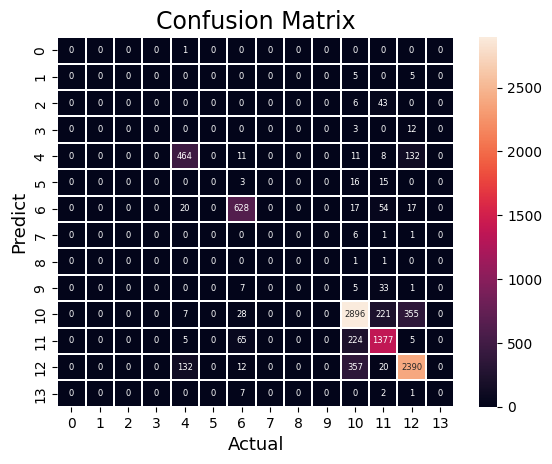

In [68]:
# compute the confusion matrix
cm = confusion_matrix(max_indices_test,max_indices_pre)
 
#Plot the confusion matrix.

sns.heatmap(cm,
            annot=True,
            fmt='g',
            linewidths= 0.2,
            annot_kws={"size": 6})
# plt.figure(figsize= (5, 5))
plt.xlabel('Actual',fontsize=13)
plt.ylabel('Predict',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)

plt.show()

## Wind Speed (km/h) And Wind Bearing (degrees)

In [69]:
def convertWind(wx, wy):
    # Chuyển đổi Wx và Wy về 'Wind Speed (km/h)'
    w_speed = np.sqrt(wx**2 + wy**2)
   
    # Chuyển đổi Wx và Wy về 'Wind Bearing (degrees)'
    w_bearing = np.arctan2(wy, wx) * 180 / np.pi
    return w_speed, w_bearing

In [70]:
w_speed_test, w_bearing_test = convertWind(y_test_inverse[:,33], y_test_inverse[:,34])
w_speed_pred, w_bearing_pred = convertWind(y_predict_inverse[:,33], y_predict_inverse[:,34])


In [71]:
# mean absolute error
mean = float(mean_absolute_error(w_speed_test, w_speed_pred))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 4.461


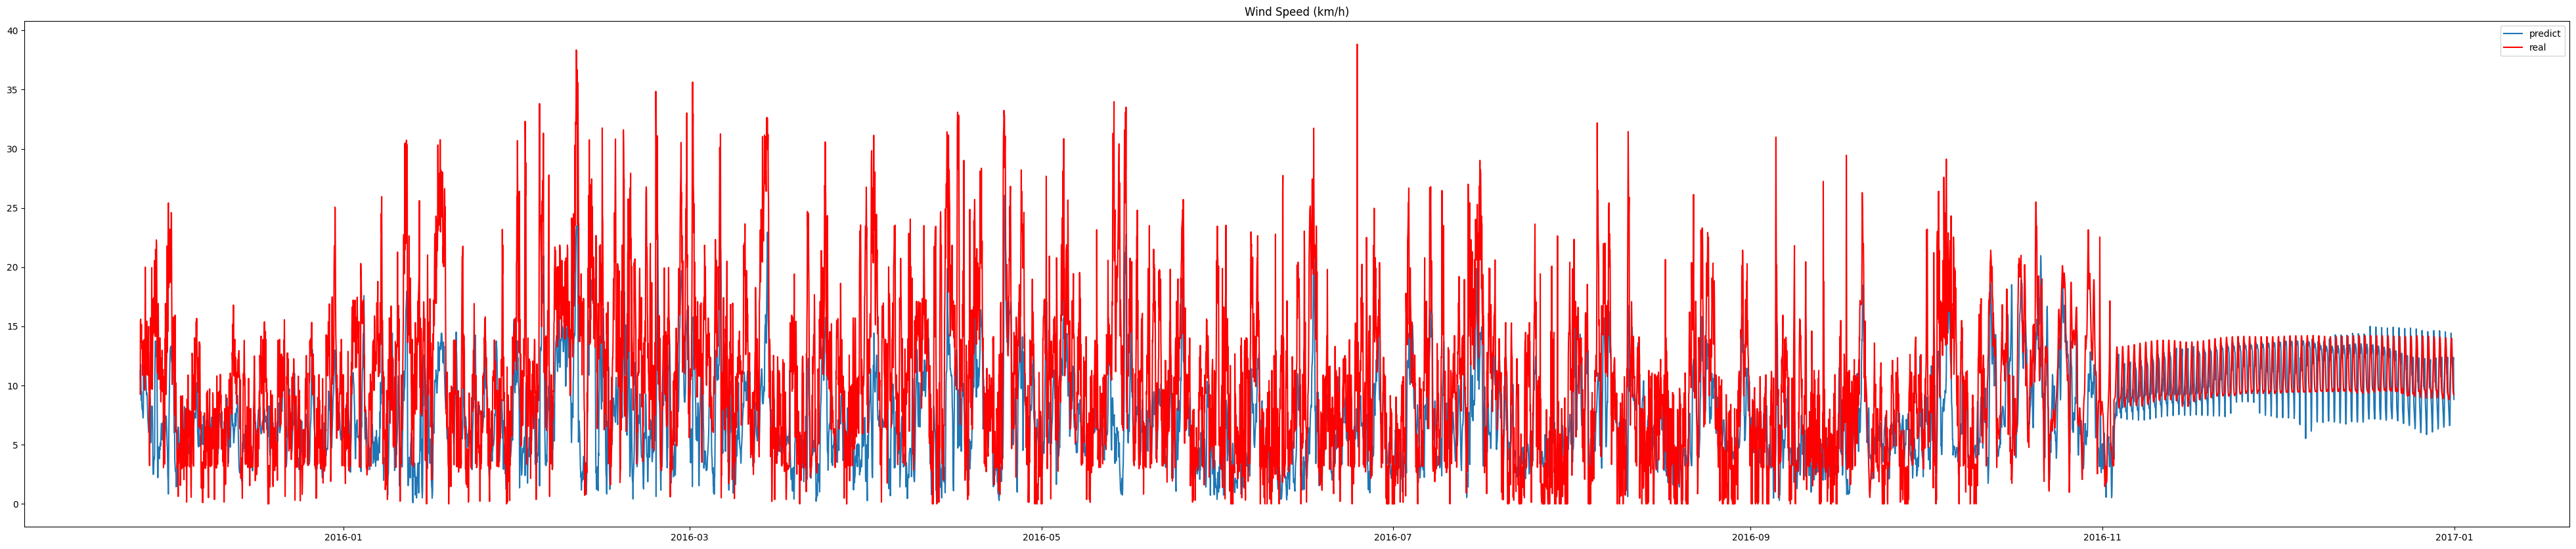

In [73]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[n_timestep:], w_speed_pred, label='predict')
plt.plot(date_time[n_timestep:], w_speed_test, c='red', label='real')
plt.title('Wind Speed (km/h)')
plt.legend()

In [75]:
# mean absolute error
mean = float(mean_absolute_error(w_bearing_test, w_bearing_pred))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 80.651


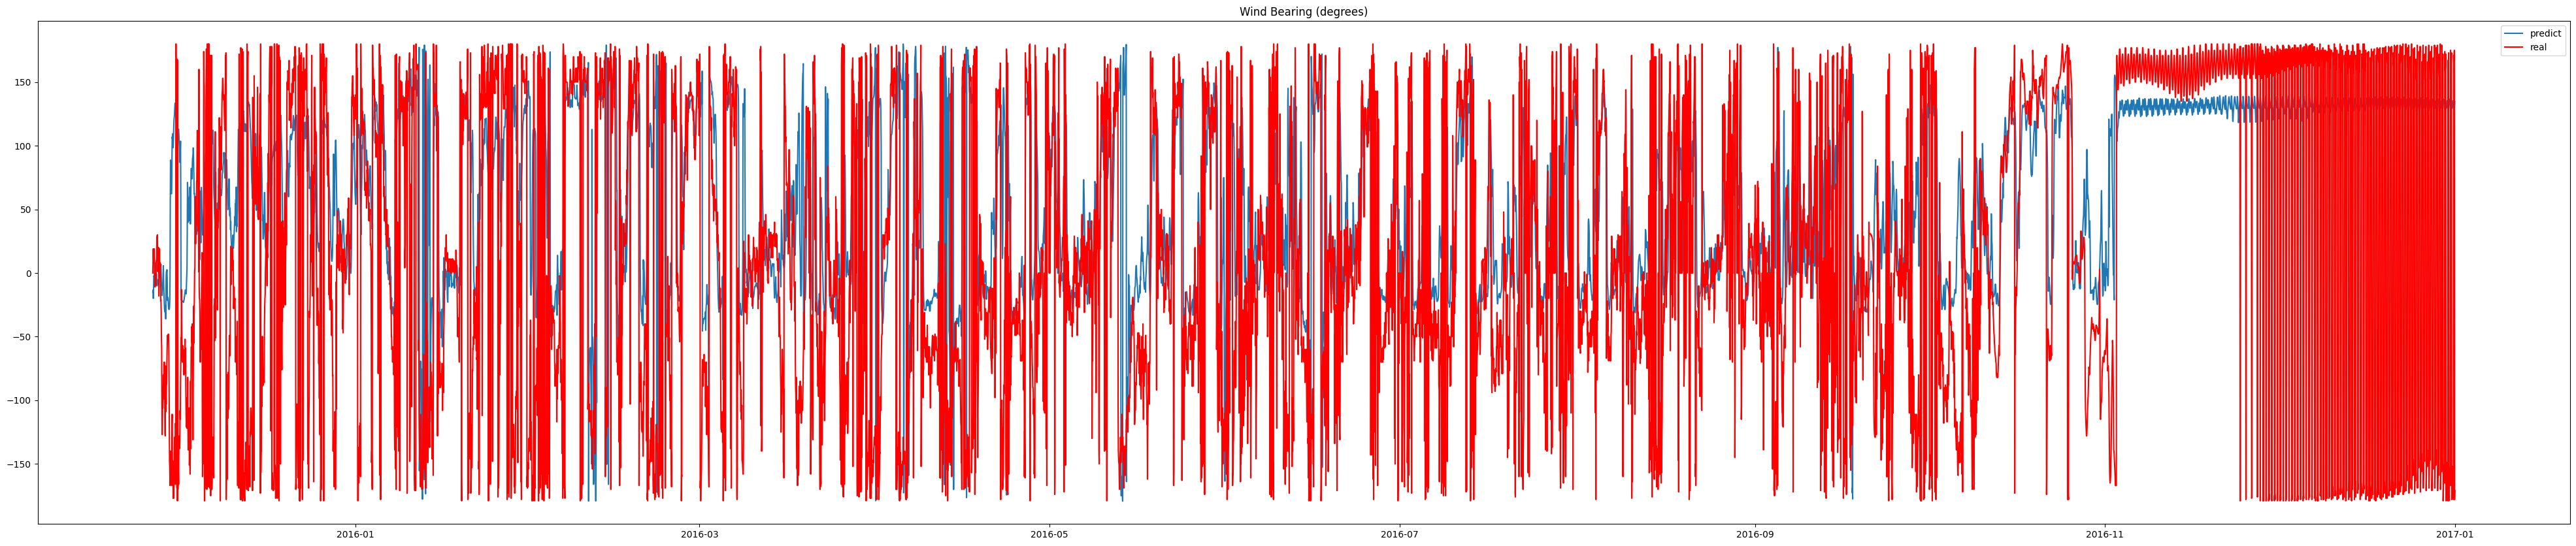

In [74]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[n_timestep:], w_bearing_pred, label='predict')
plt.plot(date_time[n_timestep:], w_bearing_test, c='red', label='real')
plt.title('Wind Bearing (degrees)')
plt.legend()